Michael Ruggiero <br>
michael@mcruggiero.com <br>
2021.05.07 <br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary-of-Problem" data-toc-modified-id="Summary-of-Problem-1">Summary of Problem</a></span></li><li><span><a href="#Libraries-Used" data-toc-modified-id="Libraries-Used-2">Libraries Used</a></span></li><li><span><a href="#Data-Generator" data-toc-modified-id="Data-Generator-3">Data Generator</a></span></li><li><span><a href="#Generate-CSVs-with-shipping-rules" data-toc-modified-id="Generate-CSVs-with-shipping-rules-4">Generate CSVs with shipping rules</a></span></li><li><span><a href="#Genetic-Algorithm" data-toc-modified-id="Genetic-Algorithm-5">Genetic Algorithm</a></span></li><li><span><a href="#Citations" data-toc-modified-id="Citations-6">Citations</a></span></li></ul></div>

## Summary of Problem

This problem was sketched out for me by Raghu. The following code is not the ideal solution. Solutions to the 3d bin packing problem exist on github, but I thought using a genetic algorithm would allow me to showcase more data-science applications.

## Libraries Used

In [27]:
from string import ascii_letters

import numpy as np
from numpy.random import randint, choice, uniform

import pandas as pd
import csv 

from matplotlib import pyplot as plt
from IPython.display import Image

## Data Generator

These are our classes to create our problem space. CSVs can be imported to test
particular problems

In [38]:
class OrderGenerator:
    """
    The purchase order generator class, creates a .csv that can be imported 
    into box solver
    """
    def __init__(self, 
                 max_items: int = 50,
                 min_items: int = 10,
                 max_dim: int = 60,
                 min_dim: int = 5,
                 max_weight: int = 1500,
                 min_weight: int = 50) -> None:
        """
        Order generator constructor
        :param max_items:   integer, max number of items in purchase order
        :param min_items:   integer, min number of items in purchase order
        :param max_dim:     integer, max number of centimeter dimension
        :param min_dim:     integer, min number of centimeter dimension
        :param max_weight:  integer, max number of grams for each object
        :param min_weight:  integer, min number of grams for each object
        """
        
        # First set number of items
        self.items = randint(min_items, max_items)
        self.max_dim = max_dim
        self.min_dim = min_dim
        self.max_weight = max_weight
        self.min_weight = min_weight
        
        # Next create a dictionary with random name and dimensions
        self.purchase_order = {}
        for i in range(self.items):
            self.purchase_order[i] = entry = {}
            entry["name"] = "".join(choice(list(ascii_letters), size = 12))
            entry["height"] = randint(self.min_dim, self.max_dim)
            entry["width"] = randint(self.min_dim, self.max_dim)
            entry["length"] = randint(self.min_dim, self.max_dim)
            entry["volume"] = entry["height"] * entry["width"] * entry["length"]
            entry["weight"] = randint(self.min_weight, self.max_weight)
            
    def make_csv(self) -> None:
        """
        Creates csv from PO.
        """
        
        # Going through pandas eats a little bit of time, but more readable
        self.df = pd.DataFrame.from_dict(self.purchase_order).T
        
        self.df = self.df.sort_values(by="volume", ascending=False)
        self.df.to_csv("purchase_order.csv")
        
class ShippingContainers:
    """
    The shipping container rule class, creates .csv that has all of the packing
    rules
    """
    def __init__(self,
                 max_types: int = 10,
                 min_types: int = 4,
                 max_dim: int = 300,
                 min_dim: int = 50,
                 max_weight: int = 100_000,
                 weight_range: float = .75,
                 max_cost: int = 25,
                 min_cost: int = 2) -> None:
        """
        Shipping rules generator
        :param max_types:    interger, max number of box classes
        :param min_types:    interger, min number of box classes
        :param max_dim:      interger, max number of centimeter dimension
        :param min_dim:      interger, min number of centimeter dimension
        :param max_weight:   interger, max weight for boxes in grams
        :param weight_range: float,    range to make for smaller boxes
        :param max_cost:     interger, max cost to ship box
        """
        self.types = randint(min_types, max_types)
        self.min_dim = min_dim
        self.costs = np.linspace(min_cost, max_cost, self.types, dtype = int)
        
        # We will apply linspace scaling between types.
        self.max_x_dim = randint(max_dim/2, max_dim)
        self.max_y_dim = randint(max_dim/2, max_dim)
        self.max_z_dim = randint(max_dim/2, max_dim)
        
        # Dimensions list this syntax is not perfect, repay debt later
        self.x_dims = np.linspace(min_dim, self.max_x_dim, self.types, dtype = int)
        self.y_dims = np.linspace(min_dim, self.max_y_dim, self.types, dtype = int)
        self.z_dims = np.linspace(min_dim, self.max_z_dim, self.types, dtype = int)
        
        # Not a perfect solution for weight range, but will do for randomization
        self.weights = np.linspace(max_weight * weight_range, 
                                   max_weight, 
                                   self.types,
                                   dtype = int)

        # Next create dictionary with scaling
        self.shipping_types = {}
        for i in range(self.types):
            self.shipping_types[i] = entry = {}
            entry["type"]  = i
            entry["height"] = self.x_dims[i]
            entry["width"] = self.y_dims[i]
            entry["length"] = self.z_dims[i]
            entry["volume"] = self.x_dims[i] * self.y_dims[i] * self.z_dims[i]
            entry["max_weight"] = self.weights[i]
            entry["cost"] = self.costs[i]
            
    def make_csv(self) -> None:
        """
        Creates csv from shipping types.
        """
        self.df = pd.DataFrame.from_dict(self.shipping_types).T
        self.df.to_csv("shipping_types.csv")

## Generate CSVs with shipping rules

In [39]:
OrderGenerator().make_csv()
ShippingContainers().make_csv()

In [40]:
shipping = pd.read_csv("shipping_types.csv", index_col = 0)
shipping.head()

,type,height,width,length,volume,max_weight,cost
0,0,50,50,50,125000,75000,2
1,1,64,76,67,325888,78125,4
2,2,78,102,84,668304,81250,7
3,3,92,128,101,1189376,84375,10
4,4,106,155,118,1938740,87500,13


In [41]:
purchase = pd.read_csv("purchase_order.csv", index_col = 0)
purchase.head()

,name,height,width,length,volume,weight
5,rbWSbqearRkF,40,55,49,107800,130
27,nIQiuSxLJFfX,58,51,35,103530,911
22,mrWCDPrRzFOE,47,51,43,103071,414
31,DQtTJBzVwDFb,57,55,31,97185,1168
29,cEfmcFiDNaFf,31,49,51,77469,566


## Genetic Algorithm

Under the current definition of our problem, the exact solution will be non-linear NP, scaling with the number of items in the purchase order. To find a reasonably timed solution we will use a genetic algorithm design. There are other options for our algorithm, but I think this design will allow me to experiment with various machine learning techniques and showcase some data science options. The rough idea for this project is outlined in this paper<a href="https://iopscience.iop.org/article/10.1088/1742-6596/1447/1/012041/meta">[1]</a>, the flow chart demonstrated in the image below.

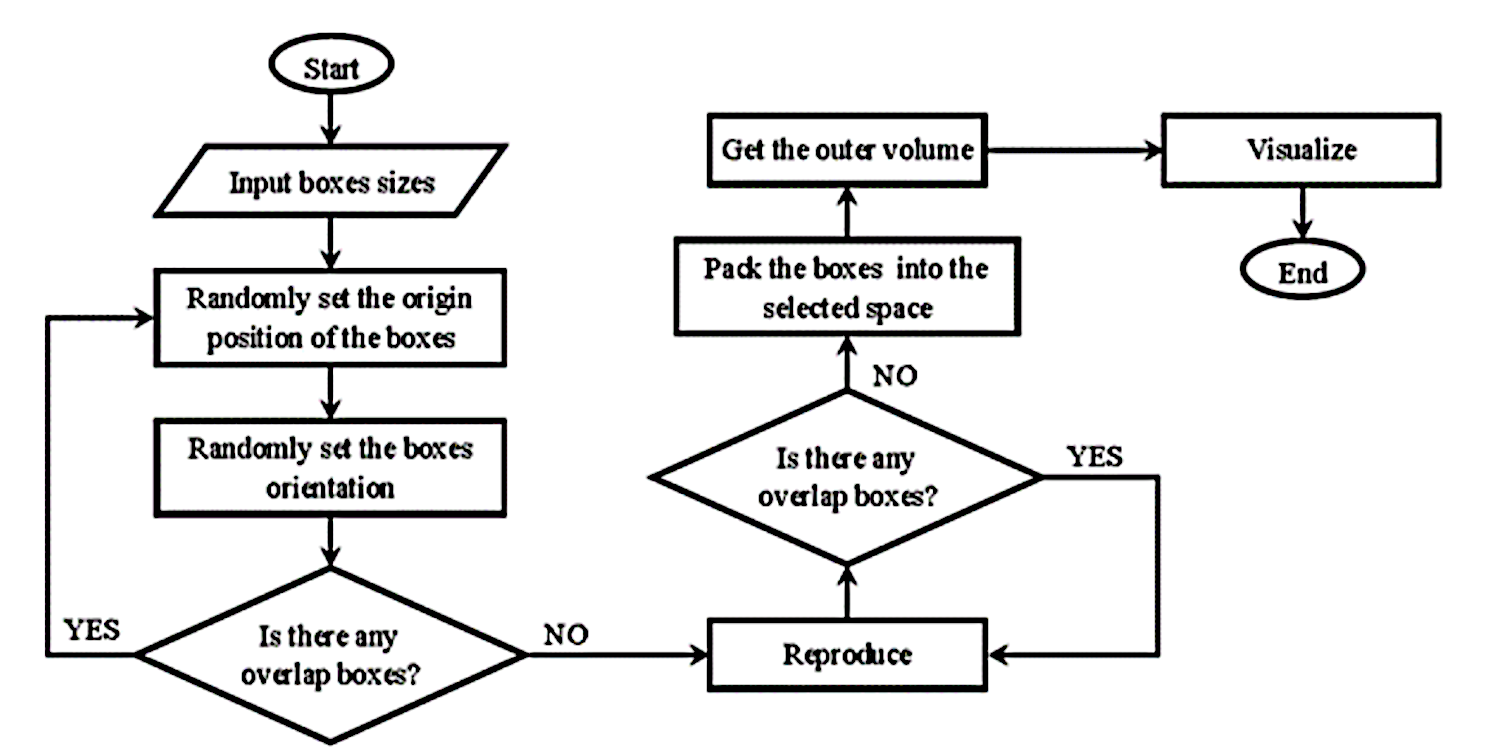

In [42]:
Image(filename = "Algo.png", width=750, height=500)

In [43]:
uniform(0,1,3)[2]

0.9834251661923206

In [23]:
class GeneticPacking:
    """
    A genetic packing algorithm to find approximate solutions to the 3D bin 
    packing problem
    """
    def __init__(self,
                 num_generations: int = 1000,
                 population: int = 1000,
                 max_size: int = 1000, 
                 csv_location: float ="") -> None:
        """
        Genetic Packing and CSV loader
        :param num_generations:    interger, number of generations to spawn
        :param population:         interger, size of each population
        :param max_size:           interger, max size of starting container
        :param csv_location:       string,   location of packing list .csv
                                             defaults to local folder
        """
        
        # Basic loading parameters
        self.num_generations = num_generations
        self.population = population
        self.max_size = 1000
        
        # CSV loading options. Defaults to local folder
        if csv_location == "":
            self.purchase = pd.read_csv("purchase_order.csv", index_col = 0)
        else:
            self.purchase = pd.read_csv(csv_location, index_col = 0)
        
        # To maintain the integrity of each chromosome, we will use a dictionary
        # structure.
        self.population = {}
        
        
        
        
        # Add x,y,z center location to the dataframe, this will be useful 
        # as we calculate the overlaps of the boxes
        self.purchase["x_center"] = 0
        self.purchase["y_center"] = 0
        self.purchase["z_center"] = 0
        
        # According to Khairuddin, et al. we will be using 4 of our columns
        # for each chromosome, length 4 x n, n number of boxes.
        
    def gene_generator(self, index) -> dict:
        """
        A random gene generator for an item in CSV
        """
        entry = dict(self.purchase.loc[index])
        
        gene = {"index": index
                "name": entry["name"]
                "coordinates": uniform(0, self.max_size,3),
                ""
                      }
        
        
        
        
    def random_populator(self) -> dict:
        """
        Creates a random individual chromosme for each item on the purchase CSV.
        """
        gene = 
        
    
    def randomize_center(self) -> object:
        """
        Initial populator for center location of packing list, useful as we 
        calculate the overlap of the boxes
        """
        
        # Check to see if we need to initialize packing list 
        dimensions = ['x_dim', 'y_dim', 'z_dim']
        if all(dim in self.purchase.columns for dim in dimensions):
            
        
        
    def chromosome_list(self) -> list:
        """
        Returns a chromosome list based on the packing order
        """
 
    def random_generator(self) -> None:
        """
        """
        pass
    
    def encode(self) -> list:
        """
        """
        pass
    
    def fitness(self) -> int:
        """
        """
        pass
    
    def select(self) -> None:
        """
        """
        pass
    
    def mate(self) -> None:
        """
        """
        pass
    
    def mutation(self) -> None:
        pass
    

SyntaxError: invalid syntax (<ipython-input-23-fb8478efe191>, line 44)

In [30]:
df = GeneticPacking().purchase

In [52]:
df

,name,x_dim,y_dim,z_dim,volume,weight,x_center,y_center,z_center
11,uYkZsFsafHcE,48,55,50,132000,1080,0,0,0
3,WYObrtKnWxrW,47,39,59,108147,212,0,0,0
27,mEenQDoBllJz,40,58,44,102080,261,0,0,0
20,FkaklXHwmFca,46,49,42,94668,1097,0,0,0
34,kZupQWJNTnuS,38,45,55,94050,128,0,0,0
10,wUkpsAvJZsGY,43,44,48,90816,1459,0,0,0
30,HubwLwgwYgVJ,44,39,51,87516,1059,0,0,0
7,suDBKCgvbMTT,58,21,48,58464,379,0,0,0
6,TqVbbwlKDQpH,53,33,33,57717,735,0,0,0
14,AelWuqrQozFy,36,51,30,55080,1020,0,0,0


In [56]:
dict(df.loc[11])["name"]

'uYkZsFsafHcE'

## Citations

[1] Khairuddin, U., Razi, N. A., Abidin, M. S., &amp; Yusof, R. (2020). Smart packing simulator for 3D packing problem using genetic algorithm. Journal of Physics: Conference Series, 1447, 012041. doi:10.1088/1742-6596/1447/1/012041